In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk


df_reviews = pd.read_csv('user_review.csv')
df_items = pd.read_csv('user_items.csv')
df_games = pd.read_csv('user_games.csv')

In [60]:
# Procesos realizados:
# Cambio de formatos de datos
# Eliminar los valores que no tienen un año especifico 
# Eliminar las filas con datos nulos de la columna review
# Eliminar las filas duplicadas
# Convertir los datos de la columna 'item_id' a formato entero
# Eliminar la columna 'posted' que ya no sera utilizada y las columnas 'funny' y 'last edited' que tienen muchos nulos y no serviran para el analisis

from datetime import datetime
def convertir_a_fecha(fecha_str):
    match = re.search(r'(\w+) (\d+), (\d+)', fecha_str)
    if match:
        mes_str, dia, año = match.groups()
        mes = datetime.strptime(mes_str, "%B").month  
        fecha = datetime(int(año), mes, int(dia))
        fecha = datetime.strptime(año, "%Y").year
        return str(fecha)
    else:
        return None


df_reviews['posted_date'] = df_reviews['posted'].apply(convertir_a_fecha)

df_reviews = df_reviews.dropna(subset=['posted_date'])

df_reviews = df_reviews.dropna(subset=['review'])

df_reviews = df_reviews.drop_duplicates(keep='first')

df_reviews['item_id'] = df_reviews['item_id'].astype(int)

df_reviews = df_reviews.drop('user_url', axis=1)
df_reviews = df_reviews.drop('posted', axis=1)
df_reviews = df_reviews.drop('funny', axis=1)
df_reviews = df_reviews.drop('last_edited', axis=1)

In [61]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48471 entries, 0 to 59276
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      48471 non-null  object
 1   item_id      48471 non-null  int32 
 2   helpful      48471 non-null  object
 3   recommend    48471 non-null  bool  
 4   review       48471 non-null  object
 5   posted_date  48471 non-null  object
dtypes: bool(1), int32(1), object(4)
memory usage: 2.1+ MB


In [62]:
df_reviews.head()

,user_id,item_id,helpful,recommend,review,posted_date
0,76561197970982479,1250,No ratings yet,True,Simple yet with great replayability. In my opi...,2011
1,76561197970982479,22200,No ratings yet,True,It's unique and worth a playthrough.,2011
2,76561197970982479,43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...,2011
3,js41637,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...,2014
4,js41637,227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...,2013


# Analisis_sentimiento(review)


In [63]:
# Procesos realizados:
# Creamos una instancia del analizador de sentimientos
# Convertimos la columna 'review' en tipo string para aplicar el modelo 
# Definimos rango para clasificar las reseñas en positivas, neutrales y negativas
# Creamos una nueva columna "sentimiento_etiqueta" para clasificar en positivo, neutral y negativo

from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

inst = SentimentIntensityAnalyzer()

df_reviews['review'] = df_reviews['review'].astype(str)

df_reviews['sentimiento'] = df_reviews['review'].apply(lambda x: inst.polarity_scores(x)['compound'])

lim_positivo = 0.2
lim_negativo = -0.2

df_reviews['sentiment_analysis'] = df_reviews['sentimiento'].apply(lambda x: 2 if x > lim_positivo else (0 if x < lim_negativo else 1))


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [64]:
df_reviews.head()

,user_id,item_id,helpful,recommend,review,posted_date,sentimiento,sentiment_analysis
0,76561197970982479,1250,No ratings yet,True,Simple yet with great replayability. In my opi...,2011,0.8481,2
1,76561197970982479,22200,No ratings yet,True,It's unique and worth a playthrough.,2011,0.2263,2
2,76561197970982479,43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...,2011,0.9117,2
3,js41637,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...,2014,0.9566,2
4,js41637,227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...,2013,0.9708,2


In [65]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48471 entries, 0 to 59276
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             48471 non-null  object 
 1   item_id             48471 non-null  int32  
 2   helpful             48471 non-null  object 
 3   recommend           48471 non-null  bool   
 4   review              48471 non-null  object 
 5   posted_date         48471 non-null  object 
 6   sentimiento         48471 non-null  float64
 7   sentiment_analysis  48471 non-null  int64  
dtypes: bool(1), float64(1), int32(1), int64(1), object(4)
memory usage: 2.8+ MB


In [66]:
# Procesos realizados:

# Filtrar valores dentro de 3 desviaciones estándar
# Convertir los datos de 'item_name' a minisculas
# Quitar duplicados
from scipy.stats import zscore

z_scores = zscore(df_items['items_count'])
df_items = df_items[(z_scores < 3) & (z_scores > -3)]  

z_scores = zscore(df_items['playtime_forever'])
df_items = df_items[(z_scores < 3) & (z_scores > -3)]  
df_items['item_name'] = df_items['item_name'].str.lower()

df_items = df_items.drop('playtime_2weeks', axis=1)

df_items = df_items.drop('steam_id', axis=1)

df_items = df_items.drop('user_url', axis=1)

df_items = df_items.drop('items_count', axis=1)

df_items = df_items.drop_duplicates(keep='first')

df_items['item_id'] = df_items['item_id'].astype(int)
df_items = df_items[df_items['playtime_forever'] != 0]

In [67]:
df_items.head()

,user_id,item_id,item_name,playtime_forever
0,76561197970982479,10,counter-strike,6
2,76561197970982479,30,day of defeat,7
8,76561197970982479,300,day of defeat: source,4733
9,76561197970982479,240,counter-strike: source,1853
10,76561197970982479,3830,psychonauts,333


In [68]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3150618 entries, 0 to 5153208
Data columns (total 4 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   user_id           object
 1   item_id           int32 
 2   item_name         object
 3   playtime_forever  int64 
dtypes: int32(1), int64(1), object(2)
memory usage: 108.2+ MB


In [69]:
# Procesos realizados:
# Eliminar los datos nulos de la columna title
# Sustituir los datos 'Free to play' por 0 en la columna 'price' 
# Convertir los datos de la colunmna 'price' a formato float 
# Cambiar el nombre de la columna "id" por "item_id"
# Cambiar el nombre de la columna "id" por "item_id"
# convertir los datos de la columna 'item_id' a entero

df_games = df_games.dropna(subset=['title'])
df_games = df_games.dropna(subset=['publisher'])
df_games = df_games.dropna(subset=['release_date'])

df_games['price'] = pd.to_numeric(df_games['price'], errors='coerce').fillna(0)

df_games['price'] = df_games['price'].astype(float)

df_games = df_games.rename(columns={'id': 'item_id'})

df_games['item_id'] = df_games['item_id'].fillna(0)
df_games['item_id'] = df_games['item_id'].astype(int)

In [70]:
df_games.head()

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,item_id,developer
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",http://steamcommunity.com/app/761140/reviews/?...,['Single-player'],4.99,False,761140,Kotoshiro
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",http://steamcommunity.com/app/643980/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",0.00,False,643980,Secret Level SRL
2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casu...",http://steamcommunity.com/app/670290/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",0.00,False,670290,Poolians.com
3,彼岸领域,"['Action', 'Adventure', 'Casual']",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"['Action', 'Adventure', 'Casual']",http://steamcommunity.com/app/767400/reviews/?...,['Single-player'],0.99,False,767400,彼岸领域
5,Trickjump Games Ltd,"['Action', 'Adventure', 'Simulation']",Battle Royale Trainer,Battle Royale Trainer,http://store.steampowered.com/app/772540/Battl...,2018-01-04,"['Action', 'Adventure', 'Simulation', 'FPS', '...",http://steamcommunity.com/app/772540/reviews/?...,"['Single-player', 'Steam Achievements']",3.99,False,772540,Trickjump Games Ltd


In [71]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24047 entries, 0 to 32133
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   publisher     24047 non-null  object 
 1   genres        23919 non-null  object 
 2   app_name      24047 non-null  object 
 3   title         24047 non-null  object 
 4   url           24047 non-null  object 
 5   release_date  24047 non-null  object 
 6   tags          23949 non-null  object 
 7   reviews_url   24046 non-null  object 
 8   specs         23762 non-null  object 
 9   price         24047 non-null  float64
 10  early_access  24047 non-null  bool   
 11  item_id       24047 non-null  int32  
 12  developer     23982 non-null  object 
dtypes: bool(1), float64(1), int32(1), object(10)
memory usage: 2.3+ MB


# ANALISIS

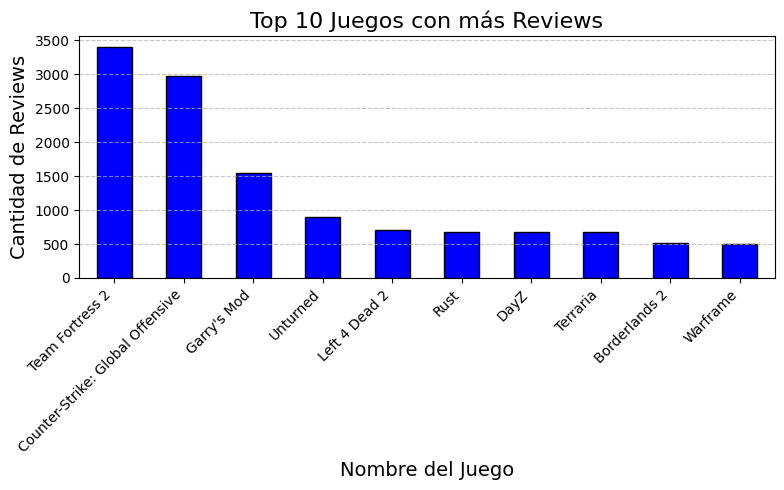

In [72]:
# 10 juegos que mas aprecen en las reviews
# Realiza un merge basado en la columna 'id_videojuego'
# Ahora df_juego contendrá todas las columnas de df_reviews y df_juegos, fusionadas por 'id_videojuego'

df_juego = pd.merge(df_reviews, df_games, on='item_id')

top_10_juegos = df_juego['title'].value_counts().head(10)

plt.figure(figsize=(8, 5))
top_10_juegos.plot(kind='bar', color='blue', edgecolor='black')  
plt.title('Top 10 Juegos con más Reviews', fontsize=16)  
plt.xlabel('Nombre del Juego', fontsize=14)  
plt.ylabel('Cantidad de Reviews', fontsize=14) 
plt.xticks(rotation=45, ha='right')  
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.tight_layout() 
plt.show()

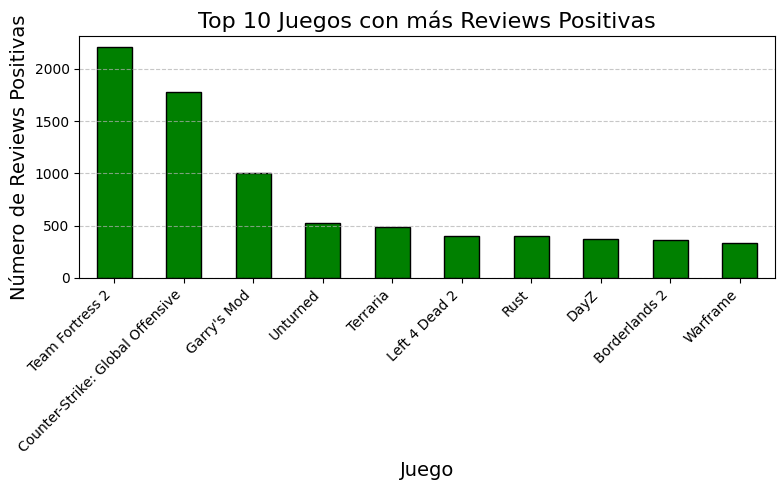

In [73]:
# Juegos con mayor cantidad de sentimientos positivos
# Realiza un merge basado en la columna 'id_videojuego'
# Se filtra solo las revisiones recomendadas (número 2)


df_juego = pd.merge(df_reviews, df_games, on='item_id')

rev_rec = df_juego[df_juego['sentiment_analysis'] == 2]

rev_por_juego = rev_rec['title'].value_counts().head(10)

plt.figure(figsize=(8, 5))
rev_por_juego.plot(kind='bar', color='green', edgecolor='black')
plt.title('Top 10 Juegos con más Reviews Positivas', fontsize=16)
plt.xlabel('Juego', fontsize=14)
plt.ylabel('Número de Reviews Positivas', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

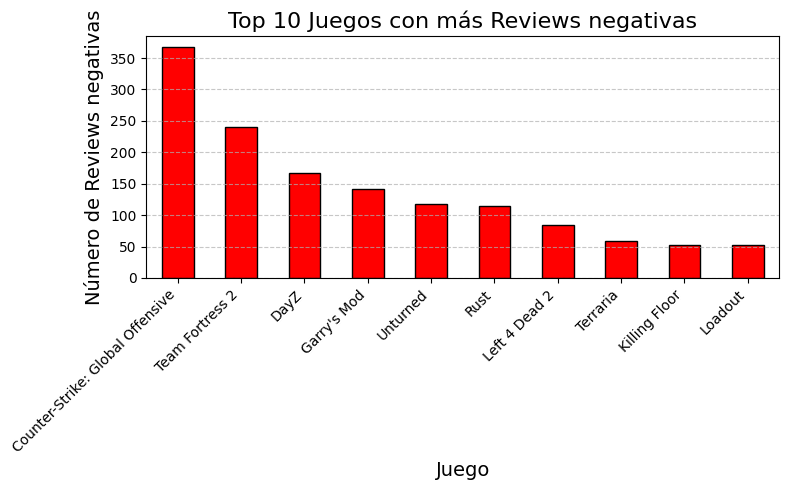

In [74]:
# Juegos con mayor cantidad de sentimientos negativo
# Realiza un merge (fusión) basado en la columna 'id_videojuego'
# Filtra solo las revisiones recomendadas (número 2)
# Obtén la cuenta de revisiones recomendadas por juego


df_completo = pd.merge(df_reviews, df_games, on='item_id')
revisiones_recomendadas = df_completo[df_completo['sentiment_analysis'] == 0]
revisiones_por_juego = revisiones_recomendadas['title'].value_counts().head(10)

plt.figure(figsize=(8, 5))
revisiones_por_juego.plot(kind='bar', color='red', edgecolor='black')
plt.title('Top 10 Juegos con más Reviews negativas', fontsize=16)
plt.xlabel('Juego', fontsize=14)
plt.ylabel('Número de Reviews negativas', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

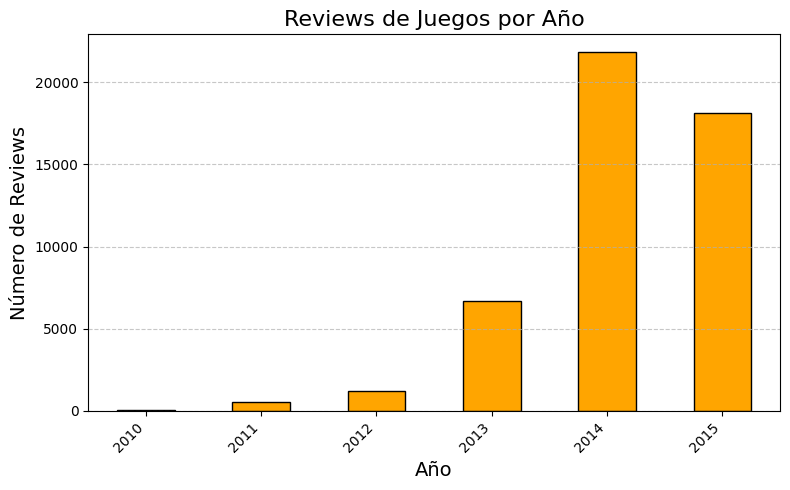

In [75]:
# Años con mas reviews

reviews_por_año = df_reviews['posted_date'].value_counts()

reviews_por_año = reviews_por_año.sort_index()

plt.figure(figsize=(8, 5))
reviews_por_año.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Reviews de Juegos por Año', fontsize=16)
plt.xlabel('Año', fontsize=14)
plt.ylabel('Número de Reviews', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

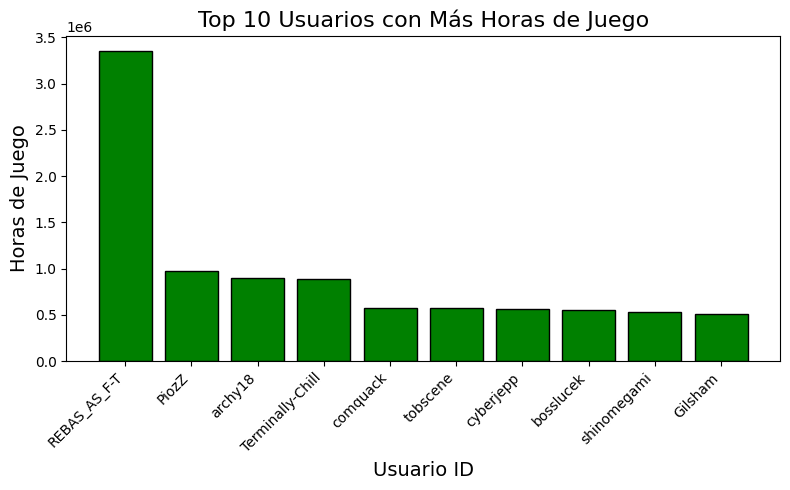

In [76]:
# Jugadores con mas horas de juego


por_usuario = df_items.groupby('user_id')['playtime_forever'].sum()

usuarios_top_horas = por_usuario.sort_values(ascending=False)

top_usuarios_horas = usuarios_top_horas.head(10)

plt.figure(figsize=(8, 5))
plt.bar(top_usuarios_horas.index, top_usuarios_horas, color='green', edgecolor='black')
plt.title('Top 10 Usuarios con Más Horas de Juego', fontsize=16)
plt.xlabel('Usuario ID', fontsize=14)
plt.ylabel('Horas de Juego', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

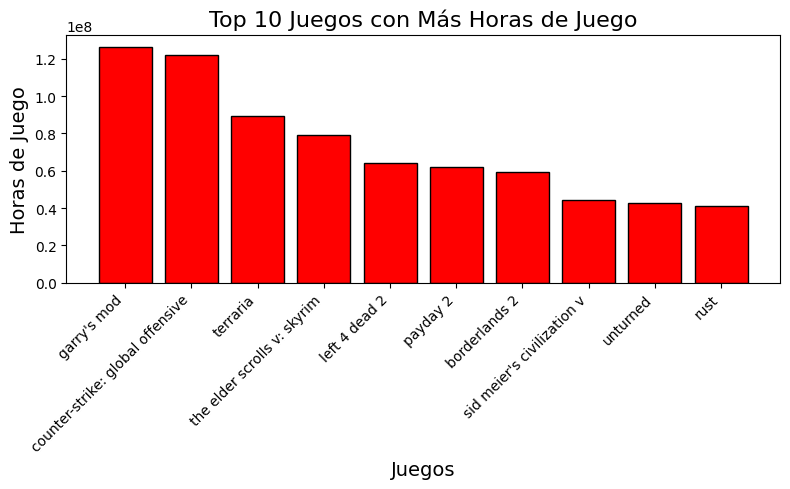

In [77]:
# Top 10 de Juegos con mas horas jugados
# Agrupa por 'item_name' y suma las horas de juego

tipo_juego = df_items.groupby('item_name')['playtime_forever'].sum()

juegos_top_horas = tipo_juego.sort_values(ascending=False)

juegos_horas = juegos_top_horas.head(10)

# Crea el gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(juegos_horas.index, juegos_horas, color='red', edgecolor='black')
plt.title('Top 10 Juegos con Más Horas de Juego', fontsize=16)
plt.xlabel('Juegos', fontsize=14)
plt.ylabel('Horas de Juego', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

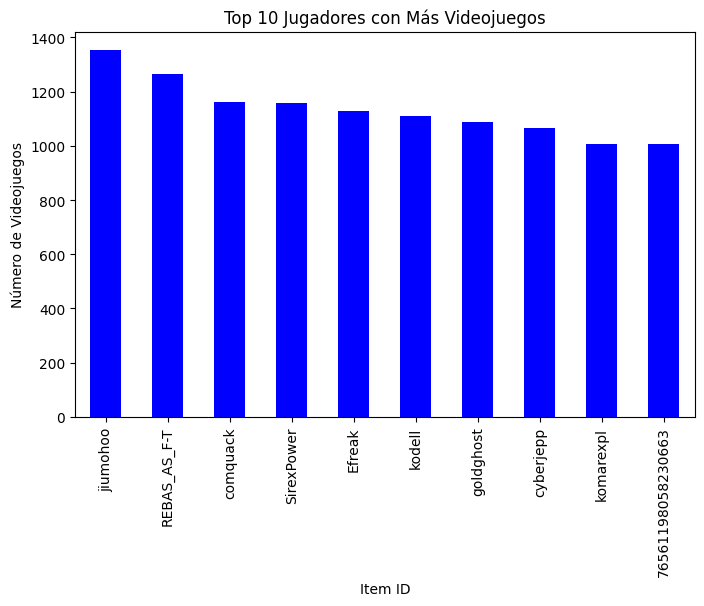

In [78]:
# Top 10 de Jugadores con mas juegos jugados

top_items = df_items['user_id'].value_counts().head(10)

plt.figure(figsize=(8, 5))
top_items.plot(kind='bar', color='blue')
plt.title('Top 10 Jugadores con Más Videojuegos')
plt.xlabel('Item ID')
plt.ylabel('Número de Videojuegos')
plt.show()

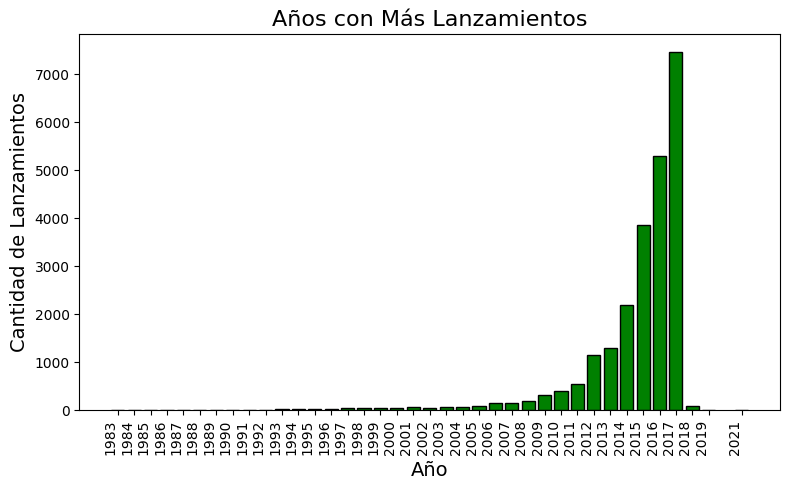

In [81]:
# Anios con mas lanzamientos
# Se convierte la columna 'release_date' al tipo de dato datetime
# Se extrae el año de la fecha y crea una nueva columna 'year'
# Se elimina las filas con fechas nulas

df = df_games

df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

df['year'] = df['release_date'].dt.year

df = df.dropna(subset=['year']).astype(str)
df_games = df

cant_lanz_anio = df['item_id'].groupby(df['year']).count()

anios_mas_lanz = cant_lanz_anio.sort_values(ascending=False)

plt.figure(figsize=(8, 5))
plt.bar(anios_mas_lanz.index.astype(int), anios_mas_lanz, color='green', edgecolor='black')
plt.title('Años con Más Lanzamientos', fontsize=16)
plt.xlabel('Año', fontsize=14)
plt.ylabel('Cantidad de Lanzamientos', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.xticks(anios_mas_lanz.index.astype(int), rotation=90, ha='right')
plt.tight_layout()
plt.show()

In [80]:
#Guardar los archivos con sus respectivas modificaciones
df_reviews.to_csv(r'reviews_eda.csv',index=False)
df_items.to_csv(r'items_eda.csv',index=False)
df_games.to_csv(r'games_eda.csv',index=False)